In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import cf
# import cfplot as cfp
import xclim
import pandas as pd
import netCDF4

from nc_processing import *
from analysis import * 

%matplotlib inline

In [2]:
def get_index_series(dates, data_dir, model, centre, var, domain, exp, project, run, grid, index_name, index_kwargs, time_files=0, index_name_file=None, index_args=[], over_write=False):
    """
    This function returns the output of the xclim index called on the time-slice of the file(s) specified, i.e. a timeseries of index values
    It will only work for indices that require a single variable. 
    
    USAGE:
    dates [list] = ['2070-01-01','2100-01-01'] - selects the time-slice to calculate over
    data_dir = '/home/users/<USERNAME>/data/' - enter your username here!
    model, centre, var, domain, exp, project, run [string] - specifies which files to 
    time_files [integer] = 0, 1, 2... - by default [0] all files will be concatenated before the time-slice is extracted. 
        this may be time-consuming for long experiments. If you know that your time slice spans, e.g. only the last 2 files then enter 2.
    index_name [string] - the name of the xclim index, e.g. 'growing_degree_days'.
    index_name_file [string] - the index name for use in the file, defaults to index_name. may need to be changed if underscores or long names problematic.
    index_args [array] - the arguments to pass to xclim. defaults to an empty list as most (all?) indices use only keyword args
    index_kwargs [dictionary] - a dictionary containing the list of keyword arguments to pass to the xclim.indices.<index_name> function. e.g.
        index_kwargs={'tas':None, # where ds_day is a dataset that has been previously loaded.
            'thresh':'10.0 degC',
            'freq':'YS',}
    
    !!!!! CRITICAL !!!!! - for the keyword argument that specifies the input variable dataarray, 'tas' in this case, enter the value: None (no quotes, 
        None is a special variable like True and False). This None entry will be replaced with the results of a call to get_time_slice()
    
    WARNING - this function will not distinguish between different calls to the same index (different index_kwargs) for a given input file,
    they will all write to the same file.
    """
    
    """
    First define directories and filenames
    """
   
    # define the data directory to search for files using lists
    ceda_dir='/badc/cmip6/data/CMIP6/{project}/{centre}/{model}/{exp}/{run}/{domain}/{var}/{grid}/latest/'.format(project=project, centre=centre, var=var, domain=domain, model=model, exp=exp, run=run, grid=grid)
    # define the base of the filename for the output file(s) using lists, note this matches the file format in the data directory except for the date_4_file section and the missing .nc. 
    out_base='{var}_{domain}_{model}_{exp}_{run}_{grid}_{time_range}'.format(var='{var}', domain=domain, model=model, exp=exp, run=run, grid=grid, time_range=dates[0]+'_'+dates[1])
    
    # use index_name_file if specified, else use index_name for the filename.
    if index_name_file is None:
        index_name_file = index_name    

    # define a simplified folder structure for our output data directory.
    data_dir_full=data_dir + '{model}/{exp}/{var}/'.format(model=model, exp=exp, var=index_name_file)
    
    # Format the output filenames
    fname_out = out_base.format(var=index_name_file) + '.nc'
    
    # specify the full output file paths
    fpath = os.path.join(data_dir_full,fname_out)
    
    """
    Check if processed files already exist, if so return those and end.
    """
    if os.path.isfile(fpath):# and not over_write: # and not over_write:
        ds_index = xr.open_dataset(fpath)
        print("loading existing files", fname_out)
        return ds_index
    
    print("processing files", fname_out)
    
    # make directory to store output netcdfs
    os.makedirs(data_dir_full, exist_ok=True)
    
    """
    Use get_time_slice() to collect the needed data and take the time-slice needed.
    """
    args=[dates,model,centre,var,domain,exp,project,run,grid,time_files]
    ds_tslice = get_time_slice(*args) # *args passes the list of values in as arguments to the get_time_slice function.

    """
    Call the xclim index function
    """
    
    func_kwargs = index_kwargs.copy() # copy needed so we don't edit the original!
    # First replace the None item in the index_kwargs with the output of get_time_slice()
    for key, value in func_kwargs.items():
        if value is None: # replace None value in dictionary with something:
            func_kwargs[key] = ds_tslice[var] # xclim.index() is expecting a dataarray so we specify the variable within the dataset
    
    # define index_to_call as the function xclim.indices.index_name() with python's getattr() function
    index_to_call = getattr(xclim.indices, index_name)
    
    # calculate the index function, filling in the arguments and keyword arguments defined previously
    ds_index = index_to_call(*index_args, **func_kwargs)
    
    """
    Finally, save output to netcdf to use again later and also return result
    """
    
    # output datasets to netcdf
    ds_index.to_netcdf(fpath)
    # overwrite ds_index with output saved to file so that pre-processed and new are identical
    ds_index_file = xr.open_dataset(fpath)
    # return index timeseries
    return ds_index_file

In [3]:
# Here's a simple function that runs the above code and spits out the ensemble 
# mean and standard deviation. "wrapping" code that you would repeat in functions saves you time and avoids the major headaches caused by changing 
# repeated code. 
def ens_quick(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files):
    # 
    ds_list = [get_index_series(dates, data_dir, model, centre, var, domain, exp, project, RUN, grid, index_name, index_kwargs, time_files=time_files) 
               for RUN in runs]
    
    # Combine the X runs into an ensemble dataset along a new "run" dimension
    ds_ens = xr.concat(ds_list, 'run')

    # Take the mean over the time (years in this case) and run dimensions
    ds_ens_mean = ds_ens.mean(dim=['time','run'])
    ds_ens_std = ds_ens.std(dim=['time','run'])
    
    # return mean and std
    return ds_ens_mean, ds_ens_std
# NOTE - all I did to create this function was indent the code (select the code and hit <TAB>),
# add a function definition line: def FUNC():
# 
# Then add a return function for the outputs, in this case the last 2 variables calculated.
# NOTE - everything produced within the function will be lost from memory except what is returned.


In [4]:
"""
Specify the common inputs
"""
data_dir='/home/users/pjirvine/data/' # !!!!!!!!!!!!! CHANGE THIS !!!!!!!!!!!!!!!!!!

model='UKESM1-0-LL'
centre='MOHC'

var='tas'
domain='day'

grid='gn'
time_files=1

# specify a list of runs
runs=['r1i1p1f2','r4i1p1f2','r8i1p1f2']

index_name = 'growing_degree_days'

# specify the arguments for the xclim index call.
index_kwargs={'tas':None, # !!!! THIS None WILL BE REPLACED WITH OUTPUT FROM get_time_slice() !!!!
              'thresh':'10.0 degC',
              'freq':'YS',
             }

In [5]:
# Load G6solar ensemble-mean datasets
exp='historical'
project='CMIP'
dates=['1960-01-01','1989-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

historical_mean, historical_std = ens_quick(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)


# Load G6solar ensemble-mean datasets
exp='G6solar'
project='GeoMIP'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

G6solar_mean, G6solar_std = ens_quick(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

# Load G6sulfur ensemble-mean datasets
exp='G6sulfur'
project='GeoMIP'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

G6sulfur_mean, G6sulfur_std = ens_quick(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

# Load ssp585 ensemble-mean datasets
project='ScenarioMIP'
exp='ssp585'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

ssp585_mean, ssp585_std = ens_quick(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

# Load ssp245 ensemble-mean datasets
project='ScenarioMIP'
exp='ssp245'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

ssp245_mean, ssp245_std = ens_quick(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

loading existing files growing_degree_days_day_UKESM1-0-LL_historical_r1i1p1f2_gn_1960-01-01_1989-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_historical_r4i1p1f2_gn_1960-01-01_1989-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_historical_r8i1p1f2_gn_1960-01-01_1989-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6solar_r1i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6solar_r4i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6solar_r8i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6sulfur_r1i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6sulfur_r4i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6sulfur_r8i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM

In [6]:
num_years = 90 # the t-test needs to know how long our sample is.
p_thresh = 0.05

# Let's wrap the ttest code from my example above (and edit it a bit) so it's easier to use.
# Note this time I will specify inputs as the mean / std datasets have names now.
def ttest_func(ds_mean_1, ds_std_1, ds_mean_2, ds_std_2, var, num_years, p_thresh=0.05):
    # p_thresh defaults to 0.05 for a 95% T-test.
    # ttest_sub returns a numpy array of P-values, where P is between 0 and 1. for 95% significance P is below 0.05
    ttest_pvalue = ttest_sub(ds_mean_1[var],ds_std_1[var],num_years,ds_mean_2[var],ds_std_2[var],num_years)

    # Let's put the ttest results into the same format as our xarray datasets
    ds_ttest = xr.full_like(ds_mean_1, 0.0) # copy dataset format from ds_mean_1 and set data values to 0.
    ds_ttest.rename(name_dict={var:'T-test'}) # rename the variable to p_value
    ds_ttest['T-test'] = (['lat','lon'],ttest_pvalue < p_thresh) # Fill in the blank values with our ttest results
    
    # Return ttest data array
    return ds_ttest['T-test']

"""
Calculate the anomalies
"""
# Calculate the anomalies:
ssp245_anom = ssp245_mean - historical_mean
ssp585_anom = ssp585_mean - historical_mean
G6sulfur_anom = G6sulfur_mean - historical_mean
G6solar_anom = G6solar_mean - historical_mean
G6sulfur_45_anom = G6sulfur_mean - ssp245_mean
G6solar_45_anom = G6solar_mean - ssp245_mean

"""
Calculate the T-test results
"""

ssp245_anom_ttest = ttest_func(ssp245_mean, ssp245_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
ssp585_anom_ttest = ttest_func(ssp585_mean, ssp585_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
G6solar_anom_ttest = ttest_func(G6solar_mean, G6solar_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
G6sulfur_anom_ttest = ttest_func(G6sulfur_mean, G6sulfur_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
G6solar_45_anom_ttest = ttest_func(G6solar_mean, G6solar_std, ssp245_mean, ssp245_std, var, num_years, p_thresh=p_thresh)
G6sulfur_45_anom_ttest = ttest_func(G6sulfur_mean, G6sulfur_std, ssp245_mean, ssp245_std, var, num_years, p_thresh=p_thresh)


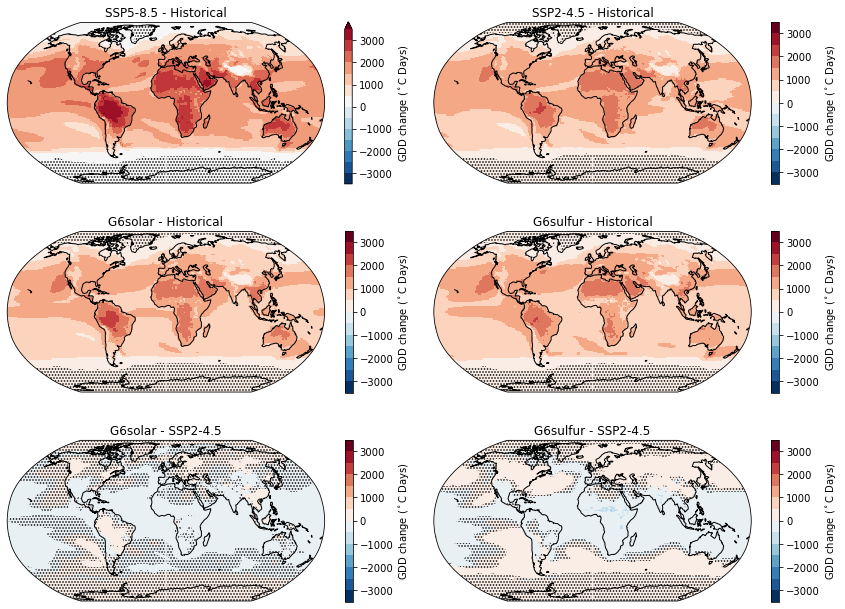

In [7]:
fig = plt.figure(figsize=(12,9)) # This sets the size of the figure (12 x 9), and hence the space 
# between figures when it tries to fit them in to the figure space. You'll need to change this if you have a different
# Number of rows / columns
cbar_label = 'GDD change ($^\circ$C Days)'
cbar_shrink = 0.8 # 80% of standard size
title_size = 12
cmap = 'RdBu_r' # a full list of colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# FYI adding '_r' on the end reverses the order, useful if you find one that would look better the other way around
# If we didn't have the 2 bottom panels with their negative values then a one-sided colorscale like 'BuGn' could work.
color_min = -3500
color_max = 3500.
levels = 15 # 7 + 7 + 1, which works as 7*500 = 3500, you want the intervals to land on round numbers
# Note, where the plot exceeds a limit it will add an extension as in the top-left plot.
# You can also manually specify the levels by entering a list instead of '15' for levels.

"""
First plot ssp5-85 anomaly
"""
# Change this stuff per panel
plot_title = 'SSP5-8.5 - Historical'
plot_data = ssp585_anom[var]
plot_ttest = ssp585_anom_ttest
position = 1

# Leave this stuff per panel (unless changing functionality)
# Create a multi-panel plot and This plot goes into the first position, counting top-left to bottom right.
# The code: (2, 2, 1) = (2 columns, 3 rows, position 1)
ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Second plot ssp2-45 anomaly
"""
plot_title = 'SSP2-4.5 - Historical'
plot_data = ssp245_anom[var]
plot_ttest = ssp245_anom_ttest
position = 2

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Third plot G6solar anomaly
"""
plot_title = 'G6solar - Historical'
plot_data = G6solar_anom[var]
plot_ttest = G6solar_anom_ttest
position = 3

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Fourth plot G6sulfur anomaly
"""
plot_title = 'G6sulfur - Historical'
plot_data = G6sulfur_anom[var]
plot_ttest = G6sulfur_anom_ttest
position = 4

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Fifth plot G6solar - SSP2-45 anomaly
"""
plot_title = 'G6solar - SSP2-4.5'
plot_data = G6solar_45_anom[var]
plot_ttest = G6solar_45_anom_ttest
position = 5

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Sixth plot G6sulfur - SSP2-45 anomaly
"""
plot_title = 'G6sulfur - SSP2-4.5'
plot_data = G6sulfur_45_anom[var]
plot_ttest = G6sulfur_45_anom_ttest
position = 6

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

fig.tight_layout()

# DRAFT cf-plot version - waiting on bug fix

In [8]:
# """
# Convert the means and standard deviations datasets to numpy arrays
# """

# historical_mean_np, historical_std_np = historical_mean[var].values, historical_std[var].values
# ssp245_mean_np, ssp245_std_np = ssp245_mean[var].values, ssp245_std[var].values
# ssp585_mean_np, ssp585_std_np = ssp585_mean[var].values, ssp585_std[var].values
# G6solar_mean_np, G6solar_std_np = G6solar_mean[var].values, G6solar_std[var].values
# G6sulfur_mean_np, G6sulfur_std_np = G6sulfur_mean[var].values, G6sulfur_std[var].values

# # We also need to extract the lons and lats as we're no longer working with the datasets that include them.
# lons = ssp245_mean.lon.values
# lats = ssp245_mean.lat.values

# # reCalculate the anomalies as numpy arrays - NOTE I've now replaced the anomalies defined above:
# ssp245_anom = ssp245_mean_np - historical_mean_np
# ssp585_anom = ssp585_mean_np - historical_mean_np
# G6sulfur_anom = G6sulfur_mean_np - historical_mean_np
# G6solar_anom = G6solar_mean_np - historical_mean_np
# G6sulfur_45_anom = G6sulfur_mean_np - ssp245_mean_np
# G6solar_45_anom = G6solar_mean_np - ssp245_mean_np

# """
# Calculate the T-test results
# """

# # Note, I'm using ttest_sub which is called inside ttest_func
# ssp245_anom_ttest_np = p_thresh > ttest_sub(ssp245_mean_np,ssp245_std_np,num_years,historical_mean_np,historical_std_np,num_years)
# ssp585_anom_ttest_np = p_thresh > ttest_sub(ssp585_mean_np,ssp585_std_np,num_years,historical_mean_np,historical_std_np,num_years)
# G6solar_anom_ttest_np = p_thresh > ttest_sub(G6solar_mean_np,G6solar_std_np,num_years,historical_mean_np,historical_std_np,num_years)
# G6sulfur_anom_ttest_np = p_thresh > ttest_sub(G6sulfur_mean_np,G6sulfur_std_np,num_years,historical_mean_np,historical_std_np,num_years)
# G6solar_anom_ttest_np = p_thresh > ttest_sub(G6solar_mean_np,G6solar_std_np,num_years,ssp245_mean_np,ssp245_std_np,num_years)
# G6sulfur_anom_ttest_np = p_thresh > ttest_sub(G6sulfur_mean_np,G6sulfur_std_np,num_years,ssp245_mean_np,ssp245_std_np,num_years)

# """
# Some useful alternative anomalies, which are much simpler to calculate with numpy arrays
# """

# # percentage anomaly
# ssp245_pc_anom_np = 100. * (ssp245_mean_np - historical_mean_np) / historical_mean_np

# # anomaly normalized by control standard deviations (tells you how large your signal is relative to noise)
# ssp245_SD_anom_np = (ssp245_mean_np - historical_mean_np) / historical_std_np

# """
# Note, this will throw some warnings as we're dividing by zero in some places.
# These alternatives are best used on data that doesn't have zero values.
# """

In [9]:
# cfp.gopen(rows=3, columns=2, bottom=0.2)
# cfp.gpos(1)
# cfp.con(f=ssp585_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
# cfp.gpos(2)
# cfp.con(f=ssp245_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
# cfp.gpos(3)
# cfp.con(f=G6solar_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
# cfp.gpos(4)
# cfp.con(f=G6sulfur_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
# cfp.gpos(5)
# cfp.con(f=G6solar_45_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
# cfp.gpos(6)
# cfp.con(f=G6sulfur_45_anom, x=lons, y=lats, ptype=1, lines=False, colorbar_position=[0.1, 0.1, 0.8, 0.02],
#         colorbar_orientation='horizontal')
# cfp.gclose()